In [1]:
from IPython.core.display import HTML

HTML("""
<style>
    div.text_cell_render, .CodeMirror pre, div.output {
        font-size: 1.2em;
        line-height: 1.2em;
    }
    .container {
        width: 100%;
    }
</style>
""")

# Poshmark Pipeline MVP

The goal of this pipeline is to scrape data from Poshmark, process it, store it, and visualize it. 

1. Scrape listings for 10 brands
2. Store using pickle
3. Format data and engineer features
4. Store using pickle
5. Explore and visualize using pandas

In [3]:
# Imports
import os
import pickle
import logging
from glob import glob
from requests import get
from datetime import datetime, date
from time import sleep
from functools import reduce

from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from bs4 import BeautifulSoup
from dateutil.parser import parse
from inflection import parameterize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
# Configure logging
logging.basicConfig(filename='scraping.log', 
                    filemode='w', 
                    format='%(asctime)s - %(message)s', 
                    datefmt='%d-%b-%y %H:%M:%S')

In [5]:
# Constants
HEADER = { 'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}
TODAY = date.today().strftime("%m_%d_%Y")

In [7]:
text = headless_download_page("https://poshmark.com/brand/Diesel-Men-Jeans?sort_by=added_desc&max_id=2")

In [2]:
# Functions to download web pages
def download_page(url):
    "Download HTML source for a given URL"
    response = get(url, headers=HEADER)
    return response

def headless_download_page(url):
    "Download HTML source for the given city using a headless Firefox instance"
    options = Options()
#     options.headless = True
    driver = webdriver.Firefox(options=options)
    driver.get(url)
    sleep(5)
    html_text = driver.page_source
    
    return html_text

def collect_pages(brand):
    "Collect all the pages for a given search query"
    count = 1
    more_pages = True
    pages = []

    while more_pages:
        url = f"https://poshmark.com/brand/{brand}-Men-Jeans?availability=all&sort_by=added_desc&max_id={count}"
        print(url)
        page = headless_download_page(url)
        pages.append(page)
        count += 1
        sleep(5)
        
        soup = BeautifulSoup(page, 'html.parser')
        btns = soup.find_all('button', class_ = 'btn--pagination')

        if btns[-1].has_attr('disabled'):
            more_pages = False
        
        if count == 11:
            more_pages = False
        
    return pages

In [13]:
# Functions to extract data from HTML
def create_soup(source):
    "Convert HTML source to BeautifulSoup object"
    soup = BeautifulSoup(source, 'html.parser')
    return soup

def extract_tiles(soup):
    "Extract all the clothing tile elements"
    containers = soup.find_all('div', class_ = 'tile')
    return containers

def extract_title(tile):
    "Extract the title string from a tile"
    try:
        title = tile.find('a', class_='tile__title').get_text(strip=True)
    except:
        title = ''
        
    return title

def extract_status(tile):
    "Extract the status from a tile"
    try:
        status = tile.find('span', class_='condition-tag').get_text(strip=True)
    except:
        status = ''
        
    return status

def extract_stock(tile):
    "Extract the stock status from a tile"
    try:
        stock = tile.find('i', class_='sold-tag').get_text(strip=True)
    except:
        stock = ''
        
    return stock

def extract_price(tile):
    "Extract the price integer from a tile"
    try:
        price = tile.find('span', attrs={'data-test': 'tile-price'}).get_text(strip=True)
    except:
        price = ''
    
    return price

def extract_size(tile):
    "Extract the size integer from a tile"
    try:
        size = tile.find('a', attrs={'data-test': 'tile-size'}).get_text(strip=True)
    except:
        size = ''
    
    return size

def extract_brand(tile):
    "Extract the brand string from a tile"
    try:
        brand = tile.find('a', attrs={'data-test': 'tile-brand'}).get_text(strip=True)
    except:
        brand = ''
    
    return brand

def extract_link(tile):
    "Extract the link string from a tile"
    try:
        link = tile.find('a', class_='tile__title').get('href')
    except:
        link = ''
    
    return link

def extract_image(tile):
    "Extract the image link string from a tile"
    try:
        image = tile.find('img').get('data-src')
    except:
        image = ''
    
    return image
    
def extract_date(url):
    "Extract the posting date from a url"
    
    try:
        start = url.find('20')
        end = start + 10
        date = url[start:end]
    except:
        date = ''
    
    return date

def combine_data(tile):
    "Run independent functions and return object of all values"
    title = extract_title(tile)
    status = extract_status(tile)
    stock = extract_stock(tile)
    price = extract_price(tile)
    size = extract_size(tile)
    brand = extract_brand(tile)
    link = extract_link(tile)
    image = extract_image(tile)
    date = extract_date(image)
        
    return {
        'title': title,
        'status': status,
        'stock': stock,
        'price': price,
        'size': size,
        'brand': brand,
        'link': link,
        'image': image,
        'date': date,
    }

In [14]:
# Functions to format the data
def format_price(price_value):
    "Remove extra text and convert to int"
    try:
        price = int(price_value.replace('$', ''))
    except:
        price = np.nan
        
    return price

def format_size(size_value):
    "Remove extra text and convert to int"
    try:    
        size = int(size_value.replace('Size: ', ''))
    except:
        size = np.nan
        
    return size

def format_brand(brand_value):
    "Make universal format"
    try:    
        brand = parameterize(brand_value, '_')
    except:
        brand = ''
        
    return brand

def format_link(link_value):
    "Add domain to link value"
    try:
        link = 'http://www.poshmark.com' + link_value
    except:
        link = ''
        
    return link

def format_date(date_value):
    "Convert string date to datetime"
    try:
        date = parse(date_value)
    except:
        date = np.nan
        
    return date

def format_record(record):
    "Format individual values of the record"
    record['price'] = format_price(record['price'])
    record['size'] = format_size(record['size'])
    record['brand'] = format_brand(record['brand'])
    record['link'] = format_link(record['link'])
    record['date'] = format_date(record['date'])
    
    return record

In [15]:
# Functions to create new features
def find_diff(date):
    "Find the amount of days an item has been listed"
    try:
        now = datetime.now()
        diff = abs((date-now).days)
    except:
        diff = np.nan
        
    return diff

def calculate_length(title):
    "Find the length of the title"
    try:
        length = len(title)
    except:
        length = np.nan
    
    return length

def identify_condition(status):
    "Create boolean value for condition status"
    try:
        condition = bool(status)
    except:
        condition = False
    
    return condition

def check_stock(stock):
    "Create boolean value for stock status"
    try:
        condition = bool(stock)
    except:
        condition = False
    
    return condition

def create_features(record):
    "Create new features from record data"
    record['diff'] = find_diff(record['date'])
    record['length'] = calculate_length(record['title'])
    record['nwt'] = identify_condition(record['status'])
    record['sold'] = check_stock(record['stock'])
    
    return record

In [16]:
# Extract raw data for multiple brands
brands = [
    'J._Crew', 'Naked_&_Famous_Denim', "Levi's", 
    'Diesel', 'Hugo_Boss', 'Mavi', 'Big_Star', 
    'Lucky_Brand', "Joes's_Jeans", 'True_Religion', 
    'Wrangler', 'Gap', 'Uniqlo'
    ]

for tag in brands:
    print('Scraping', tag)
    pages = collect_pages(tag)
    soup_objs = [create_soup(page) for page in pages]
    item_tiles = [extract_tiles(soup) for soup in soup_objs]
    combined_tiles = reduce(lambda x,y: x+y, item_tiles)
    item_objs = [combine_data(tile) for tile in combined_tiles]

    brand_name = parameterize(tag, '_')
    pickle.dump(item_objs, open(f"./data/raw/{brand_name}_{TODAY}.p", 'wb'))
    logging.info(f"Scraped {tag} page, found {len(item_objs)} items")
    
    sleep(2)

Scraping J._Crew
https://poshmark.com/brand/J._Crew-Men-Jeans?availability=all&sort_by=added_desc&max_id=1
https://poshmark.com/brand/J._Crew-Men-Jeans?availability=all&sort_by=added_desc&max_id=2
https://poshmark.com/brand/J._Crew-Men-Jeans?availability=all&sort_by=added_desc&max_id=3
https://poshmark.com/brand/J._Crew-Men-Jeans?availability=all&sort_by=added_desc&max_id=4
https://poshmark.com/brand/J._Crew-Men-Jeans?availability=all&sort_by=added_desc&max_id=5
https://poshmark.com/brand/J._Crew-Men-Jeans?availability=all&sort_by=added_desc&max_id=6
https://poshmark.com/brand/J._Crew-Men-Jeans?availability=all&sort_by=added_desc&max_id=7
https://poshmark.com/brand/J._Crew-Men-Jeans?availability=all&sort_by=added_desc&max_id=8
https://poshmark.com/brand/J._Crew-Men-Jeans?availability=all&sort_by=added_desc&max_id=9
https://poshmark.com/brand/J._Crew-Men-Jeans?availability=all&sort_by=added_desc&max_id=10
Scraping Naked_&_Famous_Denim
https://poshmark.com/brand/Naked_&_Famous_Denim-Men-

IndexError: list index out of range

In [17]:
# Process raw data 
files = [file for file in glob("./data/raw/*.p")]

for f in files:
    store = pickle.load(open(f, 'rb'))
    f_store = [format_record(item) for item in store]
    file_name = os.path.basename(f)
    pickle.dump(f_store, open(f"./data/intermediate/{file_name}", 'wb'))

In [18]:
# Add new features
files = [file for file in glob("./data/intermediate/*.p")]

for f in files:
    store = pickle.load(open(f, 'rb'))
    f_store = [create_features(item) for item in store]
    file_name = os.path.basename(f)
    pickle.dump(f_store, open(f"./data/processed/{file_name}", 'wb'))

In [15]:
# Examine the data
files = [file for file in glob("./data/processed/*.p")]
full_store = []

for f in files:
    store = pickle.load(open(f, 'rb'))
    full_store.extend(store)

In [16]:
df = pd.DataFrame(full_store)
print(df.info())
print('')
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 13 columns):
brand     3840 non-null object
date      3840 non-null datetime64[ns]
diff      3840 non-null int64
image     3840 non-null object
length    3840 non-null int64
link      3840 non-null object
nwt       3840 non-null bool
price     3840 non-null int64
size      3531 non-null float64
sold      3840 non-null bool
status    3840 non-null object
stock     3840 non-null object
title     3840 non-null object
dtypes: bool(2), datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 337.6+ KB
None

       brand       date  diff  \
0  hugo_boss 2020-04-29     2   
1  hugo_boss 2020-04-29     2   
2  hugo_boss 2020-04-29     2   
3  hugo_boss 2020-04-29     2   
4  hugo_boss 2020-04-29     2   

                                               image  length  \
0  https://di2ponv0v5otw.cloudfront.net/posts/202...      27   
1  https://di2ponv0v5otw.cloudfront.net/posts/202...      15   

In [17]:
df['brand'].unique()

array(['hugo_boss', 'diesel', 'big_star', 'mavi', 'naked_famous_denim',
       'j_crew', 'lucky_brand', 'levi_s'], dtype=object)

In [18]:
numeric_df = df[['brand', 'price', 'size', 'diff', 'length']]
numeric_df.head()

,brand,price,size,diff,length
0,hugo_boss,200,33.0,2,27
1,hugo_boss,75,36.0,2,15
2,hugo_boss,28,34.0,2,21
3,hugo_boss,50,36.0,2,42
4,hugo_boss,50,30.0,2,48


In [19]:
# Check for extreme values
numeric_df.describe()

,price,size,diff,length
count,3840.000000,3531.000000,3840.000000,3840.000000
mean,40.777344,33.322288,44.234896,34.246615
std,28.686922,2.904779,58.193196,12.324131
min,5.000000,26.000000,1.000000,4.000000
25%,25.000000,31.000000,6.000000,23.000000
50%,35.000000,33.000000,23.000000,36.000000
75%,50.000000,36.000000,63.000000,46.000000
max,500.000000,52.000000,863.000000,50.000000


In [20]:
# Compare medians by brand
numeric_df.groupby('brand')['price', 'diff', 'length'].median().reset_index().rename(
    columns={'brand':'Brand', 'price':'Price', 'diff':'Days Listed', 'length':'Title Length'})

,Brand,Price,Days Listed,Title Length
0,big_star,30.0,32.0,38.0
1,diesel,50.0,13.0,34.0
2,hugo_boss,40.0,62.0,36.0
3,j_crew,27.5,22.0,33.0
4,levi_s,29.0,2.0,33.0
5,lucky_brand,30.0,5.0,38.0
6,mavi,30.0,81.0,33.0
7,naked_famous_denim,55.0,108.0,44.0


In [22]:
# Export to CSV
df.to_csv('./data/processed/source_data.csv', index=False)
numeric_df.to_csv('./data/processed/numeric_data.csv', index=False)

## Visualizing the distributions

Use `matplotlib` to plot and analyze the distributions in our data.

In [23]:
df = pd.read_csv('./data/processed/source_data.csv')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 13 columns):
brand     3840 non-null object
date      3840 non-null object
diff      3840 non-null int64
image     3840 non-null object
length    3840 non-null int64
link      3840 non-null object
nwt       3840 non-null bool
price     3840 non-null int64
size      3531 non-null float64
sold      3840 non-null bool
status    525 non-null object
stock     985 non-null object
title     3840 non-null object
dtypes: bool(2), float64(1), int64(3), object(7)
memory usage: 337.6+ KB


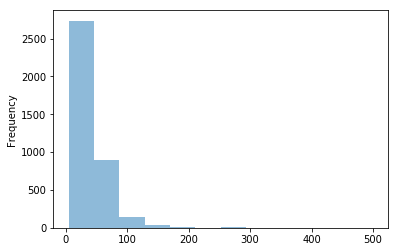

In [4]:
df['price'].plot.hist(bins=12, alpha=0.5);

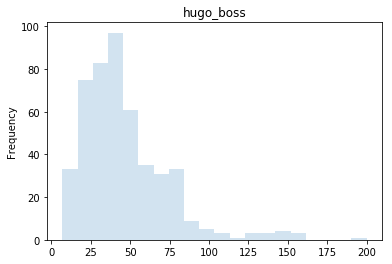

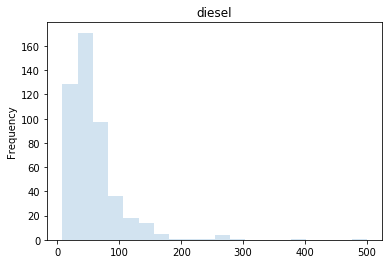

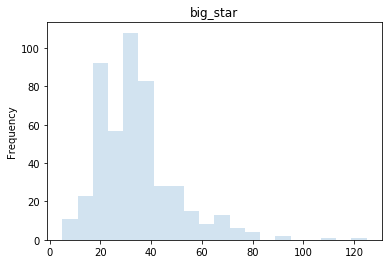

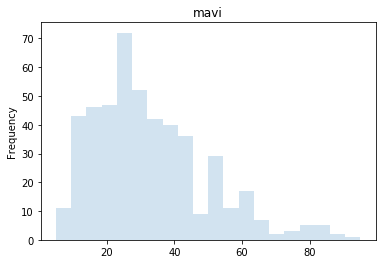

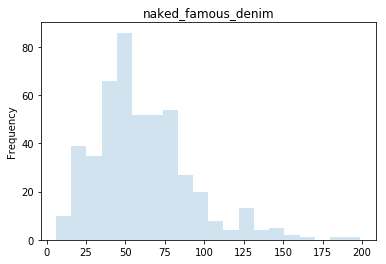

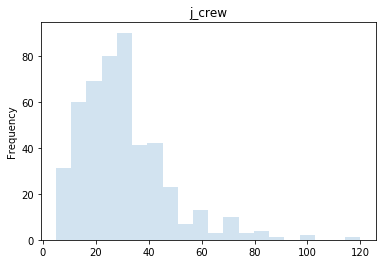

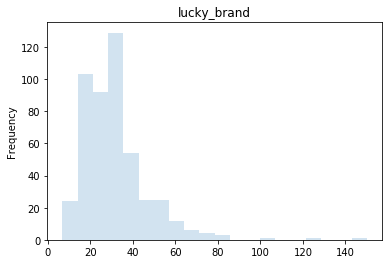

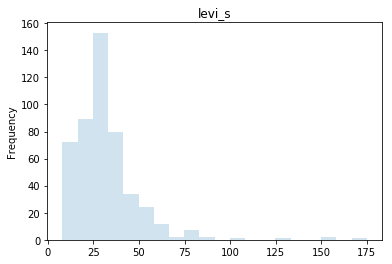

In [5]:
distinct_keys = df['brand'].unique()
for key in distinct_keys:
    plt.figure();
    df_subset = df[df.brand==key]
    df_subset['price'].plot.hist(bins=20, alpha=0.2, title=key);

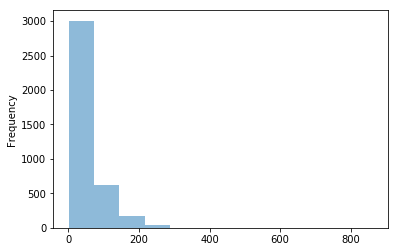

In [6]:
# Distribution of days listed
df['diff'].plot.hist(bins=12, alpha=0.5);

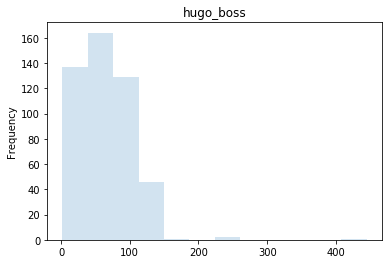

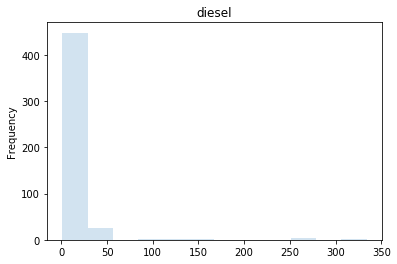

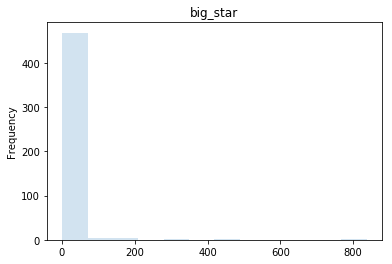

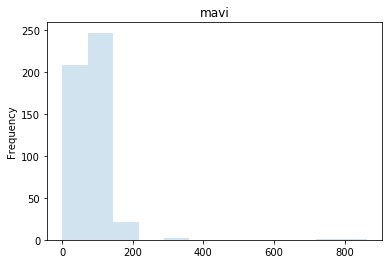

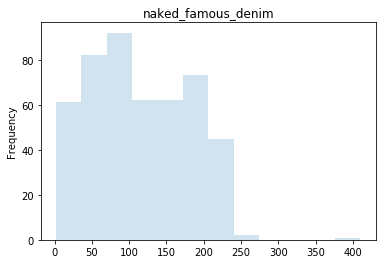

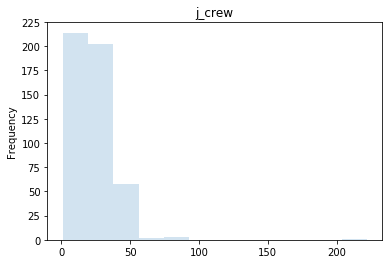

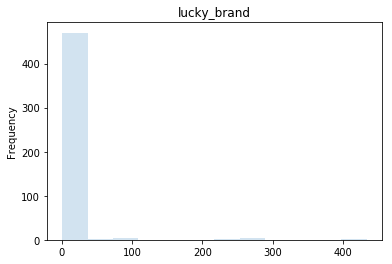

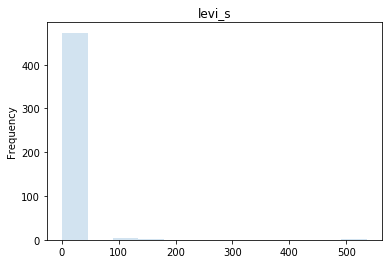

In [7]:
distinct_keys = df['brand'].unique()
for key in distinct_keys:
    plt.figure();
    df_subset = df[df.brand==key]
    df_subset['diff'].plot.hist(bins=12, alpha=0.2, title=key);

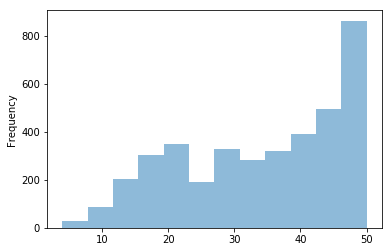

In [8]:
# Distribution of title length
df['length'].plot.hist(bins=12, alpha=0.5);

In [9]:
sold_df = df[df['sold'] == True]
sold_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 24 to 3816
Data columns (total 14 columns):
Unnamed: 0    985 non-null int64
brand         985 non-null object
date          985 non-null object
diff          985 non-null int64
image         985 non-null object
length        985 non-null int64
link          985 non-null object
nwt           985 non-null bool
price         985 non-null int64
size          955 non-null float64
sold          985 non-null bool
status        216 non-null object
stock         985 non-null object
title         985 non-null object
dtypes: bool(2), float64(1), int64(4), object(7)
memory usage: 102.0+ KB


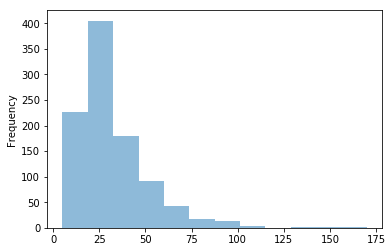

In [10]:
sold_df['price'].plot.hist(bins=12, alpha=0.5);

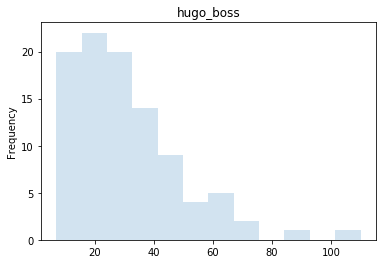

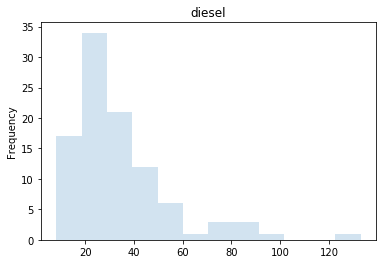

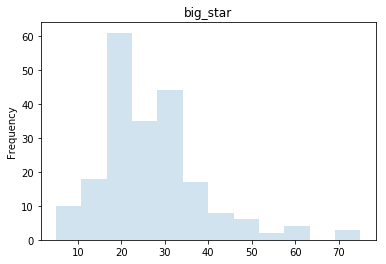

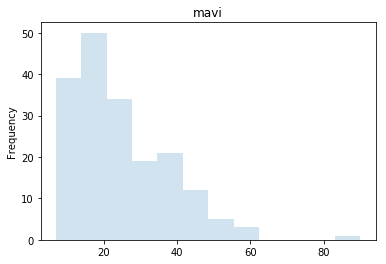

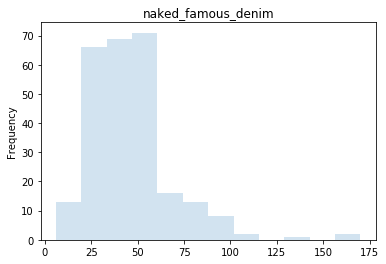

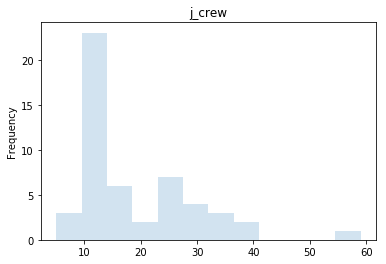

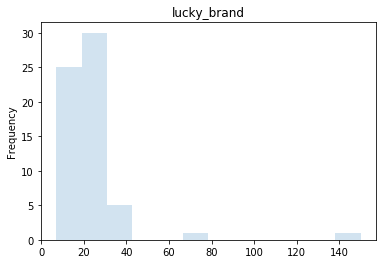

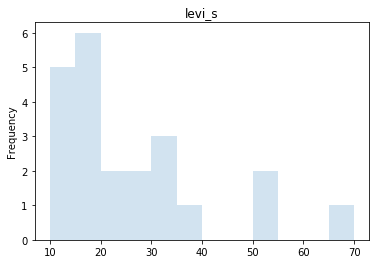

In [11]:
distinct_keys = sold_df['brand'].unique()
for key in distinct_keys:
    plt.figure();
    df_subset = sold_df[sold_df.brand==key]
    df_subset['price'].plot.hist(bins=12, alpha=0.2, title=key);

## Modeling 

Create a basic model to estimate the discount percentage.

In [27]:
df = pd.read_csv('./data/processed/source_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 13 columns):
brand     3840 non-null object
date      3840 non-null object
diff      3840 non-null int64
image     3840 non-null object
length    3840 non-null int64
link      3840 non-null object
nwt       3840 non-null bool
price     3840 non-null int64
size      3531 non-null float64
sold      3840 non-null bool
status    525 non-null object
stock     985 non-null object
title     3840 non-null object
dtypes: bool(2), float64(1), int64(3), object(7)
memory usage: 337.6+ KB


In [28]:
df2 = df[['brand', 'price', 'size', 'diff', 'length', 'nwt', 'sold']]
df2.head()

,brand,price,size,diff,length,nwt,sold
0,hugo_boss,200,33.0,2,27,False,False
1,hugo_boss,75,36.0,2,15,False,False
2,hugo_boss,28,34.0,2,21,False,False
3,hugo_boss,50,36.0,2,42,False,False
4,hugo_boss,50,30.0,2,48,True,False


In [39]:
listed_df = df[df['sold'] == False]
listed_agg = listed_df.groupby('brand')['price', 'diff', 'length'].median().reset_index().rename(
    columns={'brand':'Brand', 'price':'Listed Price', 'diff':'Days Listed', 'length':'Title Length'})
listed_agg

,Brand,Listed Price,Days Listed,Title Length
0,big_star,35.0,21.0,35.5
1,diesel,50.0,11.0,34.0
2,hugo_boss,45.0,57.0,35.5
3,j_crew,28.0,20.0,32.0
4,levi_s,29.0,2.0,33.0
5,lucky_brand,30.0,5.0,38.0
6,mavi,35.0,66.0,33.0
7,naked_famous_denim,75.0,78.0,44.0


,Brand,Listed Price
0,big_star,35.0
1,diesel,50.0
2,hugo_boss,45.0
3,j_crew,28.0
4,levi_s,29.0
5,lucky_brand,30.0
6,mavi,35.0
7,naked_famous_denim,75.0


In [41]:
sold_df = df[df['sold'] == True]
sold_agg = sold_df.groupby('brand')['price', 'diff', 'length'].median().reset_index().rename(
    columns={'brand':'Brand', 'price':'Sold Price', 'diff':'Days Listed', 'length':'Title Length'})
sold_agg

,Brand,Sold Price,Days Listed,Title Length
0,big_star,25.0,44.0,40.0
1,diesel,27.0,22.0,32.0
2,hugo_boss,25.0,88.5,38.5
3,j_crew,13.0,29.0,39.0
4,levi_s,17.5,2.5,30.5
5,lucky_brand,20.0,7.0,41.0
6,mavi,22.0,100.5,34.0
7,naked_famous_denim,40.0,137.0,44.0


In [42]:
merged_inner = pd.merge(left=listed_agg[['Brand', 'Listed Price']], 
                        right=sold_agg[['Brand', 'Sold Price']], 
                        left_on='Brand', right_on='Brand')

In [48]:
merged_inner['Extra Discount'] = round(1 - (merged_inner['Sold Price'] / merged_inner['Listed Price']), 2) * 100

In [49]:
merged_inner

,Brand,Listed Price,Sold Price,Extra Discount
0,big_star,35.0,25.0,29.0
1,diesel,50.0,27.0,46.0
2,hugo_boss,45.0,25.0,44.0
3,j_crew,28.0,13.0,54.0
4,levi_s,29.0,17.5,40.0
5,lucky_brand,30.0,20.0,33.0
6,mavi,35.0,22.0,37.0
7,naked_famous_denim,75.0,40.0,47.0
